# Projektni zadatak - Opružno njihalo [Josip Gregorić]

Ovaj projekt obuhvaća simulaciju sustava opružnog njihala obješenog o čvrsto ovjesište. Generalni plan projekta, pa tako i ove bilježnice izgleda kao:

I.) Uvozi modula i osnovne deklaracije varijabli;<br>
II.) Simbolički izvod E.-L. jednadžbi i njihovo rješenje;<br>
III.) Gradnja funkcije za simulaciju gibanja sustava (početni uvjeti i transformacije brzina, izvlačenje rješenja i provjera energija i transformacija, iscrtavanje grafova).<br>
IV.) Prezentacija nekih zanimljivih slučajeva.<br>

(_Prva verzija ovo zadatka napravljena je Eulorovom metodom numeričkog rješavanja diferencijalnih jednadžbi, no rješenja su divergirala već za vrijednost parametra $t=5s$ (vrijeme praćenja gibanja) pri koraku od $dt=0.01s$ (uz to što je metoda bila vrlo spora). Zato je napravljena ova verzija s ___odeint___ metodom._)

### I. Uvozi modula i osnovne deklaracije varijabli.

**Uvoz modula:**

Prije svega, standardnom procedurom uvozimo relevantne module.

In [53]:
from sympy import *
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
%matplotlib inline

**Deklaracije i derivacije:**

Definiramo relevantne varijable kao simboličke objekte,

In [54]:
#Parametri
t,g,k,m,L0=symbols('t,g,k,m,L_0')

#Varijable vremena
r,theta=symbols('r,theta',cls=Function)

r=r(t)
theta=theta(t)

In [55]:
rdot=diff(r,t)
thetadot=diff(theta,t)

rdotdot=diff(rdot,t)
thetadotdot=diff(thetadot,t)

...pa tako i Kartezijeve koordinate s pripadnim transformacijama u naš (ponešto modificirani) polarni sustav.

In [56]:
x=r*sin(theta)
y=r*cos(theta)

xdot=diff(x,t)
ydot=diff(y,t)

**Energije i Lagranžijan:**

Izražavamo kinetičku i potencijalnu energiju sustava, definiramo Lagranžijan i maksimalno ga pojednostavljujemo.

In [57]:
T=(m/2*(xdot**2+ydot**2)).simplify()
U=((k*(r-L0)**2)/2-m*g*y).simplify()

L=(T-U).simplify()
L

g*m*r(t)*cos(theta(t)) - k*(L_0 - r(t))**2/2 + m*(r(t)**2*Derivative(theta(t), t)**2 + Derivative(r(t), t)**2)/2

### II.  Simbolički izvod E.-L. jednadžbi i njihovo rješenje.

Uobičajenim postupkom izvodimo jednadžbe gibanja, te ih rješavamo po akceleracijama kuta otklona i odmaka.

In [58]:
LEr=(diff(diff(L,rdot),t)-diff(L,r)).simplify()
LEtheta=(diff(diff(L,thetadot),t)-diff(L,theta)).simplify()

#Rješenja za akceleracije koordinata r i theta:
solrdotdot=( solveset(LEr,rdotdot).args[0] ).simplify()
solthetadotdot=( solveset(LEtheta,thetadotdot).args[0] ).simplify()
display(solrdotdot,solthetadotdot)

(g*m*cos(theta(t)) + k*(L_0 - r(t)) + m*r(t)*Derivative(theta(t), t)**2)/m

-(g*sin(theta(t)) + 2*Derivative(r(t), t)*Derivative(theta(t), t))/r(t)

Snižavamo red dif. jed. uvođenjem nove varijable:
Neka je: $u_r=dr/dt$ i $u_\theta=d\theta/dt$. 
Tada je: $u_r/dt=dr^2/dt^2$ i $u_\theta=d\theta^2/dt^2$. Pritom moramo simboličke funkcije preinačiti u Python funkcije koje primaju brojeve, a za to koristimo poznatu naredbu _lambdify_.

In [59]:
ur_dt=lambdify( (t,r,rdot,theta,thetadot,k,L0,g,m), solrdotdot, modules='sympy') #iako ne ovisi eskpl. o vremenu stavljamo radi
utheta_dt=lambdify( (t,r,rdot,theta,thetadot,k,L0,g,m), solthetadotdot, modules='sympy') #iako ne ovisi o masi stavljamo sve radi preglednosti

Definiramo novi vektor $\vec{F}=(r,u_r,\theta,u_\theta)$ u svrhu korištenja _odeint_ metode rješavanja ovog sustava dif. jed. te njegovu vremensku derivaciju $d\vec{F}/dt$ kao funkciju:

In [60]:
def dF_dt(F,t,k,L0,g,m):
    r1, ur1, theta1, utheta1 = F
    return [ ur1 , ur_dt(t,r1,ur1,theta1,utheta1,k,L0,g,m) , utheta1 , utheta_dt(t,r1,ur1,theta1,utheta1,k,L0,g,m) ]

### III. Gradnja funkcije za simulaciju gibanja sustava.

In [61]:
def Njihalo(konstanta, L0, m, x0, y0, vx0, vy0,vrijeme):
    t=np.linspace(0,vrijeme,1001)
    g=9.81
    
    #Početni uvjeti i transformacije brzina:
    r0=np.sqrt(x0**2+y0**2)
    
    if y0!=0:
        theta0=np.arctan(x0/y0)
    elif x0==0:
        theta0=0
    elif x0>0:
        theta0=np.pi/2
    else:
        theta0=-np.pi/2
    
    vrad0=vx0*np.sin(theta0) + vy0*np.cos(theta0)
    vtheta0=(vx0*np.cos(theta0) - vy0*np.sin(theta0))/r0
    
    #Rješavanje dif. jednadžbe:
    sol=odeint(dF_dt, y0=[r0, vrad0 ,theta0 ,vtheta0], t=t, args=(konstanta,L0,g,m))
    
    #Izvlačenje rješenja (najlakše je transponirati matricu):
    rs=sol.T[0]
    thetas=sol.T[2]
    
    vrads=np.array([sol.T[1][i] for i in range(0,len(t))])
    vthetas=np.array([sol.T[3][i] for i in range(0,len(t))])
    
    vxs=np.array([vrads[i] * np.sin(thetas[i]) + rs[i] * np.cos(thetas[i]) * vthetas[i] for i in range(0,len(t))])
    vys=np.array([vrads[i] * np.cos(thetas[i]) - rs[i] * np.sin(thetas[i]) * vthetas[i] for i in range(0,len(t))])
        
    xs=np.array([rs[i]*np.sin(thetas[i]) for i in range(0,len(t))])
    ys=np.array([rs[i]*np.cos(thetas[i]) for i in range(0,len(t))])
    
    #Energije pomoću polarnih i kartezijevih koordinata u svrhu provjere transformacija brzina, kao i ostalih rješenja:
    
    T1=np.array([0.5*m*(vxs[i]**2+vys[i]**2) for i in range (0,len(t))])
    U1=np.array([0.5*konstanta*(np.sqrt(xs[i]**2 + ys[i]**2) - L0)**2 - m*g*ys[i] for i in range(0,len(t))]) 
    
    T2=np.array([0.5*m*(vrads[i]**2 + (rs[i]**2)*(vthetas[i]**2)) for i in range (0,len(t))])
    U2=np.array([0.5*konstanta*(rs[i] - L0)**2 - m*g*rs[i]*np.cos(thetas[i]) for i in range(0,len(t))])
    
    E1=np.array([T1[i] + U1[i] for i in range (0,len(t))]) #energija je konstantna, iscrtano tijekom testiranja.
    E2=np.array([T2[i] + U2[i] for i in range (0,len(t))]) #energija je konstantna, iscrtano tijekom testiranja.
    
    #Iscrtavanje grafova:
    plt.style.use("bmh")
    fig = plt.figure(figsize=(9, 8), layout="tight")
    spec = fig.add_gridspec(4, 6)

    #vx,vy-t
    ax1 = fig.add_subplot(spec[0, 0:3])
    ax1.plot(t,vxs,label="$v_x(t)$")
    ax1.plot(t,vys,label="$v_y(t)$")
    ax1.set_title("$v_x,v_y-t$")
    ax1.legend(loc="lower right")

    #x,y-t
    ax2 = fig.add_subplot(spec[1, 0:3])
    ax2.plot(t,xs,label="$x(t)$")
    ax2.plot(t,ys,label="$y(t)$")
    ax2.set_title("$x,y-t$")
    ax2.legend(loc="lower right")
    
    #putanja
    ax3 = fig.add_subplot(spec[0:2, 3:])
    ax3.axis("scaled")
    ax3.set_xlim(-12.5,12.5);
    ax3.set_ylim(20,-5) #set_xylim za subplotove
    ax3.scatter(0,0,color="k");
    ax3.plot(xs,ys)
    ax3.set_title("$x-y$")
    
    #vx-vy
    ax4 = fig.add_subplot(spec[2:4,0:2])
    ax4.axis("equal")
    ax4.plot(vxs,vys)
    ax4.set_title("$v_x-v_y$")
    
    #vx-x
    ax5 = fig.add_subplot(spec[2:4,2:4])
    ax5.axis("equal")
    ax5.plot(xs,vxs)
    ax5.set_title("$v_x-x$")
    
    #vy-y
    ax6 = fig.add_subplot(spec[2:4,4:6])
    ax6.axis("equal")
    ax6.plot(ys,vys)
    ax6.set_title("$v_y-y$")
    
    return 

### IV.) Neki zanimljivi slučajevi.

### a) Limes šipke (k velik).

Pazeći na početne uvjete (da opruga ne bude rastegnuta), dobivamo ponašanje običnog matematičkog njihala.

CPU times: total: 0 ns
Wall time: 0 ns


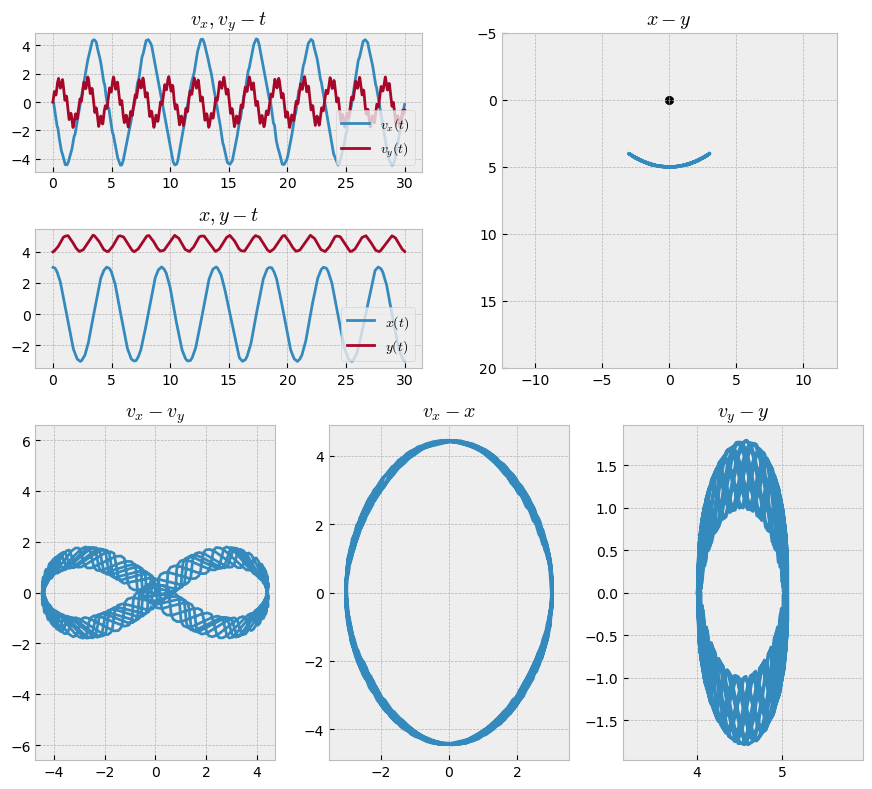

In [62]:
%time
Njihalo(konstanta=3000, L0=5, m=10, x0=3, y0=4, vx0=0, vy0=0, vrijeme=30)

### b) Viseća masa na opruzi (nema njihanja).

CPU times: total: 0 ns
Wall time: 0 ns


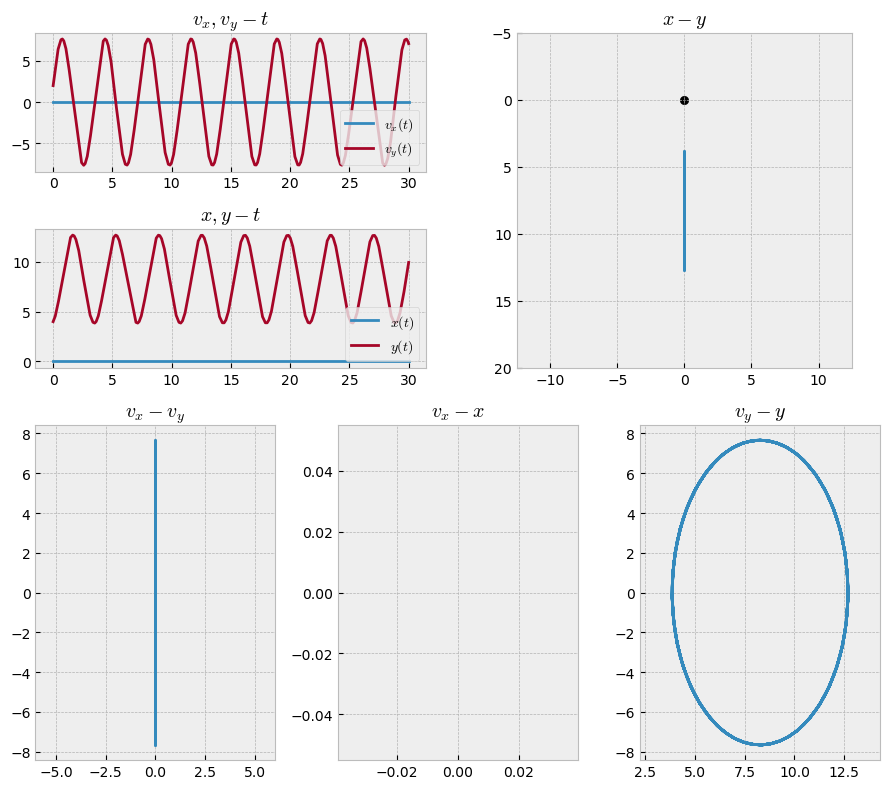

In [63]:
%time
Njihalo(konstanta=30, L0=5, m=10, x0=0, y0=4, vx0=0, vy0=2, vrijeme=30)

### c) Titranje u modu.

Zahtijevanjem da je prirodna frekvencija titranja duljine radij-vektora jednaka prirodnoj frekvenciji titranja kuta otklona $\sqrt{\frac{k}{m}}=\sqrt{\frac{g}{l}}$ dobivamo zanimljive figure na grafovima putanje i grafovima brzina:

CPU times: total: 0 ns
Wall time: 0 ns


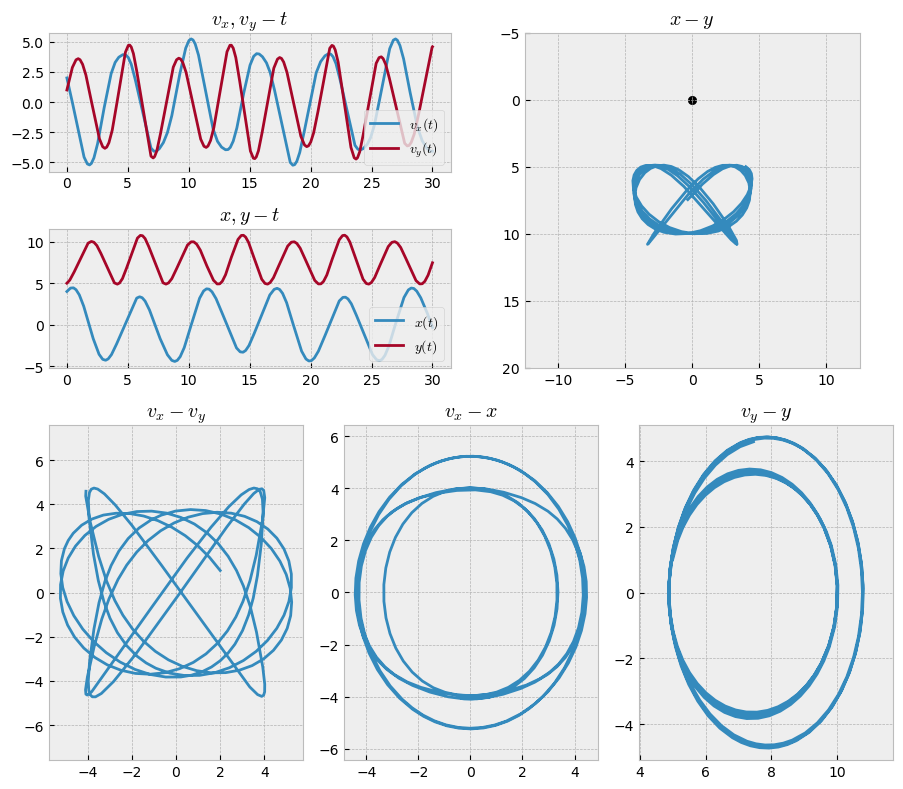

In [64]:
%time
Njihalo(konstanta=50, L0=4, m=20, x0=4, y0=5, vx0=2, vy0=1, vrijeme=30)

### d) Dodatni slučajevi.

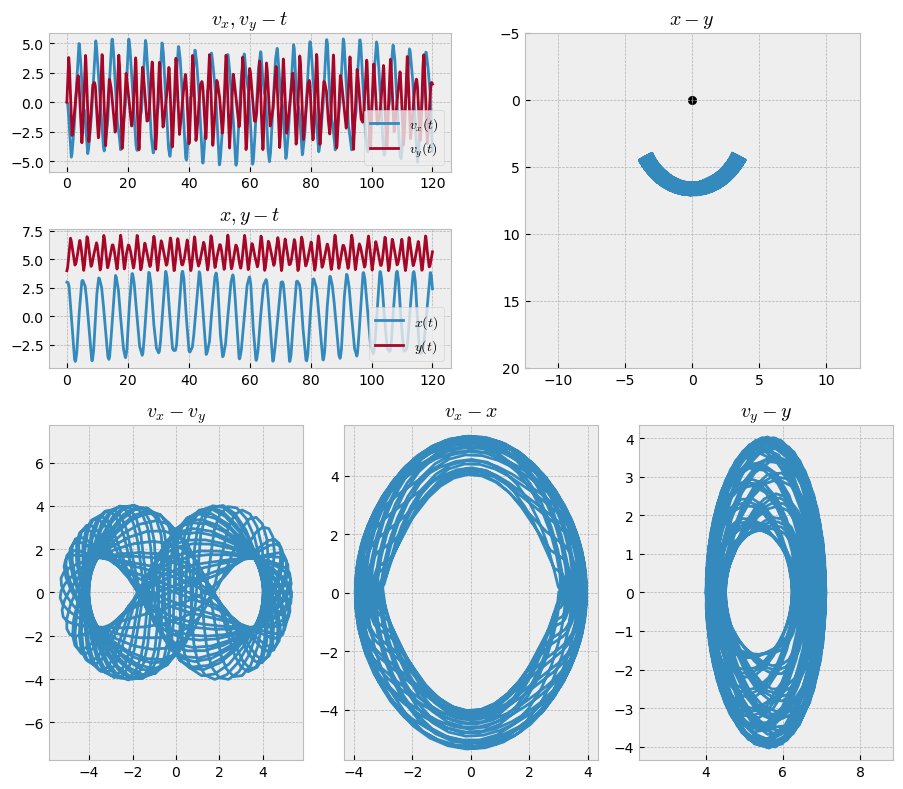

In [65]:
Njihalo(konstanta=100, L0=5, m=10, x0=3, y0=4, vx0=0, vy0=0, vrijeme=120)

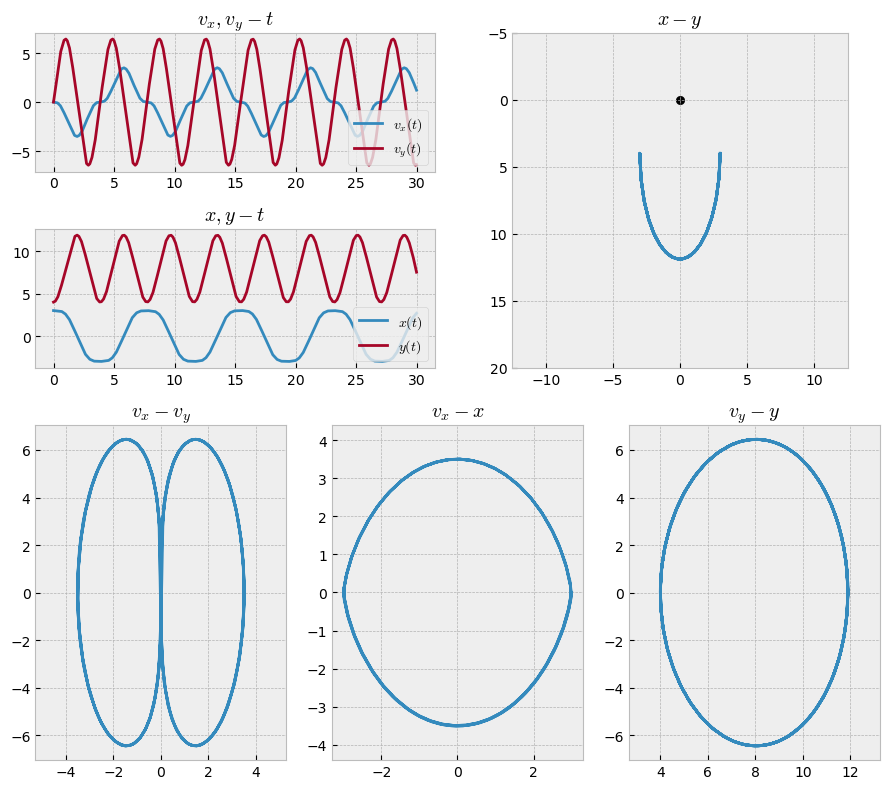

In [66]:
Njihalo(konstanta=30, L0=5, m=10, x0=3, y0=4, vx0=0, vy0=0, vrijeme=30)

                                                                                                       Josip Gregorić